In [1]:
#!pip install qulacs
#!pip install matplotlib
#!pip install numpy
#!pip install scipy

In [2]:
from qulacs import Observable, QuantumState, QuantumCircuit, ParametricQuantumCircuit
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# 簡単な量子回路学習を実行してみる

今回は簡単な量子回路学習をシミュレートしてみます。

## 回路作成と出力の定義

回路を以下のように作ります。可視化しやすいように、訓練できるパラメータを 2 パラメータだけ入れた回路です。

In [3]:
n_qubits = 2
circuit = ParametricQuantumCircuit(n_qubits)

# add input gate
circuit.add_parametric_RY_gate(0, 0.0)
circuit.add_parametric_RY_gate(1, 0.0)

# add parametrized circuit
circuit.add_parametric_RY_gate(0, 0.0)
circuit.add_CNOT_gate(0,1)
circuit.add_parametric_RY_gate(0, 0.0)

出力 (予測値) は 1 qubit 目の $Z$ 期待値を取ることにします。1次元 (スカラー) の入力データと、パラメータ $\theta = (\theta_0, \theta_1)$ を受け取って、サンプリングによって出力を返す関数を作ります。

In [4]:
state = QuantumState(n_qubits)
observable = Observable(n_qubits)
observable.add_operator(1., "Z 0")
def predict(x, theta, n_shots=1000):
    
    # the first two parameters are the input gates
    circuit.set_parameter(0, x)
    circuit.set_parameter(1, x)
    
    # the next two parameters are the parametric (trainable) gates
    circuit.set_parameter(2, theta[0])
    circuit.set_parameter(3, theta[1])
    
    # run circuit and sample
    state.set_zero_state()
    circuit.update_quantum_state(state)
    
    # if n_shots is inf, return exact expectation value
    if n_shots == np.inf:
        return observable.get_expectation_value(state)
    
    # else perform sampling
    else:
        samples = np.array(state.sampling(n_shots))
        # the first qubit is the output qubit
        return np.sum((-1)**(samples%2))/n_shots

## データの用意

今回のモデルは $\sin^2 x$ を完璧に表現することのできるモデルになっています。そこで教師データとして $\sin^2 x$ にノイズを加えたものを用意して、それを学習させることにします。

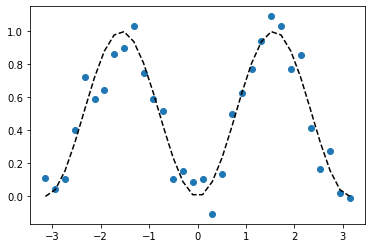

In [5]:
n_data = 32
X = np.linspace(-np.pi, np.pi,n_data)
y_clean = np.sin(X)**2
y = y_clean + np.random.randn(n_data)*0.1
plt.scatter(X,y)
plt.plot(X, y_clean, color="black", linestyle="dashed")
plt.show()

## コスト関数の定義と可視化
コスト関数を定義します。ここではコスト関数として 2 乗誤差
$$L(\theta) = \sum_i (y_i - \langle Z(x_i,\theta)\rangle)^2$$
を使います。入力データ $x_i$ と教師データ $y_i$ のセット $\{(x_i, y_i)\}$ とパラメータ $\theta$ を与えると、コスト関数の値を返すような関数を定義します。

In [6]:
def get_cost(X, y, theta, n_shots=1000):
    predictions = np.zeros_like(X)
    for i, x in enumerate(X):
        predictions[i] = predict(x, theta, n_shots)
    return np.sum((predictions - y)**2)

このコスト関数がどのような形をしているか、可視化してみましょう。正確なコスト関数の値を知りたいので、ここでは `n_shots=np.inf` として、厳密な期待値をプロットします

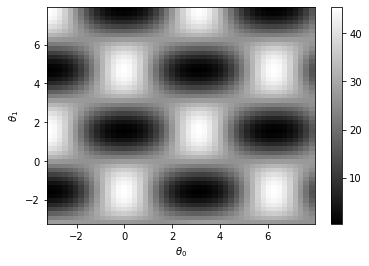

In [7]:
theta0 = np.linspace(-np.pi, 5*np.pi/2, 50)
theta1 = np.linspace(-np.pi, 5*np.pi/2, 50)
theta0, theta1 = np.meshgrid(theta0, theta1)
cost_grid = np.zeros_like(theta0)
n_shots = 1000
for i in range(50):
    for j in range(50):
        cost_grid[i,j] = get_cost(X, y, [theta0[i,j], theta1[i,j]], n_shots=np.inf)
plt.pcolor(theta0, theta1, cost_grid, shading="nearest", cmap="gray")
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$")
plt.colorbar()
plt.show()

## 勾配を計算する関数を準備する
[パラメータシフト法](./06_parameter_shift_rule.ipynb) を使った勾配最適化を行いたいので、そのための関数を準備します。コスト関数の勾配は
$$
\begin{align}
\frac{\partial L}{\partial \theta} &= \frac{\partial }{\partial \theta} \sum_i (y_i - \langle Z(x_i,\theta)\rangle)^2 \\
&= \sum_i 2(\langle Z(x_i,\theta)-y_i\rangle)\frac{\partial \langle Z(x_i,\theta)\rangle}{\partial \theta}
\end{align}
$$
と書けることに注意します。

In [8]:
# calculate d<Z>/d\theta 
def get_prediction_grad(x, theta, n_shots=1000):
    grad_vector = np.zeros_like(theta)
    tmp_theta = np.copy(theta)
    for i in range(len(theta)):
        tmp_theta[i] += np.pi/2
        plus = predict(x, tmp_theta, n_shots)
        tmp_theta[i] -= np.pi
        minus = predict(x, tmp_theta, n_shots)
        grad_vector[i] = (plus-minus)/2
        tmp_theta[i] = theta[i]
    return grad_vector

# calculate dL/d\theta
def get_cost_gradient(X, y, theta, n_shots=1000):
    predictions = np.zeros_like(X)
    prediction_grads = np.zeros((len(X),len(theta)))
    cost_gradient = np.zeros_like(theta)
    for i, x in enumerate(X):
        predictions[i] = predict(x, theta, n_shots)
        prediction_grads[i] = get_prediction_grad(x, theta, n_shots)
    return np.sum(2*(predictions-y)*prediction_grads.T, axis=1)

正しく計算できていることを、有限差分と比較して確認しましょう。

In [9]:
# get gradient of general function f(\theta) by finite difference
def get_gradient_by_finite_diff(f, params, eps=1e-6):
    grad_vector = np.zeros_like(params)
    tmp_params = np.copy(params)
    for i in range(len(params)):
        tmp_params[i] += eps
        plus = f(tmp_params)
        tmp_params[i] -= 2*eps
        minus = f(tmp_params)
        grad_vector[i] = (plus-minus)/2/eps
        tmp_params[i] = params[i]
    return grad_vector

print(get_gradient_by_finite_diff(lambda theta: get_cost(X,y,theta,n_shots=np.inf), [0.3, 0.4]))
print(get_cost_gradient(X,y,[0.3,0.4],n_shots=np.inf))

[  1.96532846 -23.91106797]
[  1.96532846 -23.91106796]


パラメータシフト法による勾配が正しく書けていることがわかりました。いよいよパラメータの訓練に進みます。

## 勾配法による学習
上のカラープロットから、学習の初期パラメータ $\theta_{\mathrm{init}}$ として良さげな (見栄えが良くなりそうな) 点を選びます。ここでは $\theta=(3.1,2.0)$ を取ることにします。

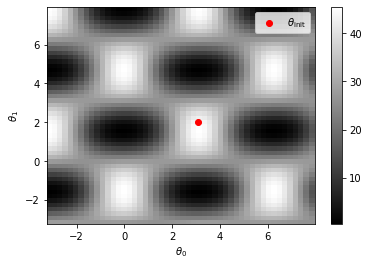

In [10]:
theta_init = np.array([3.1, 2.0])
plt.pcolor(theta0, theta1, cost_grid, shading="nearest", cmap="gray")
plt.colorbar()
plt.scatter(*theta_init, color="red", label=r"$\theta_{\mathrm{init}}$")
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$")
plt.legend()
plt.show()

単純な勾配降下法によって学習して、その様子を可視化しましょう。

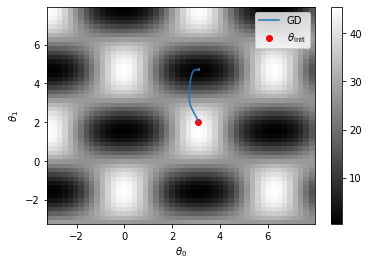

In [11]:
tmp_theta = np.copy(theta_init)
n_steps = 100
rate = 0.01
n_shots = 1000
theta_history_naive_gd = np.zeros((n_steps+1, 2))
theta_history_naive_gd[0] = theta_init
for i in range(n_steps):
    tmp_theta -= rate*get_cost_gradient(X, y, tmp_theta, n_shots)
    theta_history_naive_gd[i+1] = tmp_theta
plt.pcolor(theta0, theta1, cost_grid, shading="nearest", cmap="gray")
plt.plot(theta_history_naive_gd[:,0], theta_history_naive_gd[:,1], label="GD")
plt.colorbar()
plt.scatter(*theta_init, color="red", label=r"$\theta_{\mathrm{init}}$")
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$")
plt.legend()
plt.show()

うまく最適化できていそうに見えます。学習結果もプロットしてみます。

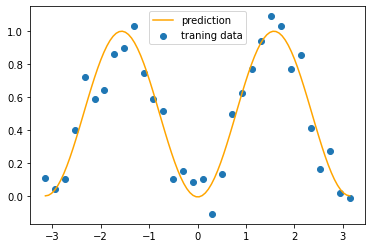

In [12]:
X_verify = np.linspace(-np.pi, np.pi, 100)
prediction = [predict(x, tmp_theta, n_shots=np.inf) for x in X_verify]
plt.scatter(X, y, label="traning data")
plt.plot(X_verify, prediction, color="orange", label="prediction")
plt.legend()
plt.show()

きれいにフィッティングすることができました。

## 確率的勾配降下法による学習

[パラメータシフト法](./06_parameter_shift_rule.ipynb)でも見たように、確率的勾配降下法はそもそも出力が確率的である量子回路と相性が良いです。ここでは色々な確率的勾配降下法を試してみます。

### Shot 数を減らした学習
[パラメータシフト法](./06_parameter_shift_rule.ipynb)でもやりましたが、確率的勾配降下法の精神に乗っ取ると、各ステップにおけるサンプリングの数が 1 であっても学習できます。ここではこれを試してみます。

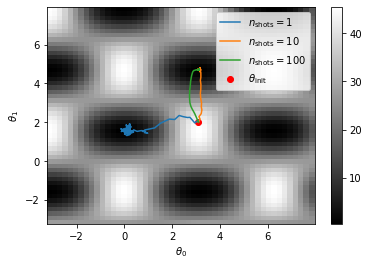

In [13]:
n_steps = 100
rate = 0.01
n_shots_list = [1, 10, 100]
theta_history_list = []
for n_shots in n_shots_list:
    tmp_theta = np.copy(theta_init)
    theta_history = np.zeros((n_steps+1, 2))
    theta_history[0] = theta_init
    for i in range(n_steps):
        tmp_theta -= rate*get_cost_gradient(X, y, tmp_theta, n_shots)
        theta_history[i+1] = tmp_theta
    theta_history_list.append(theta_history)
plt.pcolor(theta0, theta1, cost_grid, shading="nearest", cmap="gray")
plt.colorbar()
for i, n_shots in enumerate(n_shots_list):
    plt.plot(theta_history_list[i][:,0], theta_history_list[i][:,1], label=r"$n_{\mathrm{shots}}=$"+str(n_shots))
plt.scatter(*theta_init, color="red", label=r"$\theta_{\mathrm{init}}$")
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$")
plt.legend()
plt.show()

ノイズが大きくなるにつれてたどる経路もジグサグしてしまいますが、一応ちゃんと学習できています。

### 入力データも確率的に選ぶ
機械学習の分野で確率的勾配降下法といえば、普通は最適化の各ステップにおいて、ランダムに選んだ一部の訓練データのみを使ってパラメータを更新していくものを指します。これもやってみましょう。 

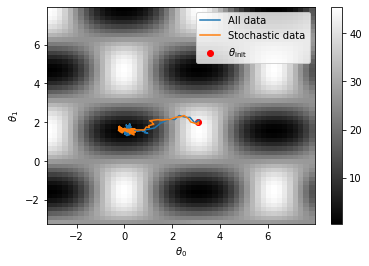

In [14]:
n_epochs = 100
rate = 0.01
n_shots = 1
tmp_theta = np.copy(theta_init)
theta_history = np.zeros((n_steps+1, 2))
theta_history[0] = theta_init

# numpy の permutation 機能のための random number generator
rng = np.random.default_rng()

# Xをランダムに並び替えて更新を n_epoch 回繰り返す
for i in range(n_epochs):
    # ランダムに並び替えられた X, y を生成
    permuted_index = rng.permutation(len(X))
    X_permuted = X[permuted_index]
    y_permuted = y[permuted_index]

    # 並び替えたデータを順に使って学習
    for x, t in zip(X_permuted, y_permuted):
        tmp_theta -= rate*get_cost_gradient([x,], [t,], tmp_theta, n_shots)
        theta_history[i+1] = tmp_theta
        
plt.pcolor(theta0, theta1, cost_grid, shading="nearest", cmap="gray")
plt.colorbar()
plt.plot(theta_history_list[0][:,0], theta_history_list[0][:,1], label="All data")
plt.plot(theta_history[:,0], theta_history[:,1], label="Stochastic data")
plt.scatter(*theta_init, color="red", label=r"$\theta_{\mathrm{init}}$")
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$")
plt.legend()
plt.show()

この場合、量子コンピュータは各更新において 4 shot しか動かしていないため、各更新において得られている情報はたったの 4 ビットだけです。それでもそれなりに学習ができることがわかります。

### 発展編
まだ確率的にしてしまえるところとして、
- 更新するパラメータをランダムに選ぶ
- パラメータシフト法の $\pm \pi/2$ のどちらかをランダムに選ぶ

が残っています。これらもやってみると面白いかもしれません。

また、上では単純な勾配降下法しか扱いませんでしたが、
- AdaGrad
- Adam
- RMSprop
- ...

などのモダンな最適化法を組み合わせるのも面白いと思います。